In [1]:
import os
import gc  # Garbage collector for memory management

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR


import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
def normalize_data(data, min_val=None, max_val=None):
    if min_val is None or max_val is None:
        min_val = data.min()
        max_val = data.max()
    # Normalize to [0, 1]
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data, min_val, max_val


In [4]:
def create_datasets_convolutional(bkg_file, signals_files, blackbox_file, events=None, test_size=0.2, val_size=0.2, input_shape=57, batch_size=64):
    
    # Step 1: Load and process BACKGROUND data (SM data)
    with h5py.File(bkg_file, 'r') as file:
        full_data = file['Particles'][:, :, :input_shape]  # Load only the relevant features
        np.random.shuffle(full_data)  # Shuffle the data
        if events:
            full_data = full_data[:events, :, :]  # Limit the number of events
    
    # Normalize background data
    full_data, bkg_min, bkg_max = normalize_data(full_data)
    
    # Step 2: Split the data into training, validation, and testing sets
    X_train, X_temp = train_test_split(full_data, test_size=test_size, shuffle=True)
    X_val, X_test = train_test_split(X_temp, test_size=val_size)
    
    # Clean up memory
    del full_data, X_temp
    gc.collect()
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor)
    val_dataset = TensorDataset(X_val_tensor)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Clean up memory
    del X_train, X_val, X_train_tensor, X_val_tensor
    gc.collect()
    
    # Step 3: Load and process SIGNAL data (BSM data)
    bsm_data_list = []
    for signal_file in signals_files:
        with h5py.File(signal_file, 'r') as f:
            signal_data = f['Particles'][:, :, :input_shape]
            # Normalize signal data using background normalization parameters
            signal_data, _, _ = normalize_data(signal_data, min_val=bkg_min, max_val=bkg_max)
            bsm_data_list.append(signal_data)
    
    # Concatenate all BSM data
    bsm_data = np.concatenate(bsm_data_list, axis=0)
    
    # Convert BSM data to a PyTorch tensor
    bsm_tensor = torch.tensor(bsm_data, dtype=torch.float32)
    
    # Create TensorDataset and DataLoader for test data
    test_dataset = TensorDataset(bsm_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Clean up memory
    del bsm_data_list, bsm_data, bsm_tensor
    gc.collect()
    
    # Step 4: Load and process BLACKBOX data
    with h5py.File(blackbox_file, 'r') as f:
        blackbox_data = f['Particles'][:, :, :input_shape]
        # Normalize blackbox data using background normalization parameters
        blackbox_data, _, _ = normalize_data(blackbox_data, min_val=bkg_min, max_val=bkg_max)
    
    # Convert blackbox data to a PyTorch tensor
    blackbox_tensor = torch.tensor(blackbox_data, dtype=torch.float32)
    
    # Create TensorDataset and DataLoader for blackbox data
    blackbox_dataset = TensorDataset(blackbox_tensor)
    blackbox_loader = DataLoader(blackbox_dataset, batch_size=batch_size, shuffle=False)
    
    # Clean up memory
    del blackbox_data, blackbox_tensor
    gc.collect()
    
    return train_loader, val_loader, test_loader, blackbox_loader

# Example usage:
background_file = 'dataset/background_for_training.h5'
signal_files = [
    'dataset/Ato4l_lepFilter_13TeV_filtered.h5',
    'dataset/hChToTauNu_13TeV_PU20_filtered.h5',
    'dataset/hToTauTau_13TeV_PU20_filtered.h5',
    'dataset/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5'
]
blackbox_file = 'dataset/BlackBox_background_mix.h5'

train_loader, val_loader, test_loader, blackbox_loader = create_datasets_convolutional(
    bkg_file=background_file,
    signals_files=signal_files,
    blackbox_file=blackbox_file,
    events=100000,  # Process only the first 100,000 events
    test_size=0.2,
    val_size=0.2,
    input_shape=4,
    batch_size=64
)

In [6]:
# Function to print random samples without feature names
def print_random_samples(data_loader, num_samples=5):
    # Retrieve one batch from the DataLoader
    data_iter = iter(data_loader)
    batch = next(data_iter)
    
    # Convert batch to a NumPy array for easier manipulation
    batch_np = batch[0].numpy()  # Assuming the dataset contains only one tensor per sample
    
    # Randomly select a few samples from the batch
    indices = np.random.choice(range(batch_np.shape[0]), num_samples, replace=False)
    random_samples = batch_np[indices]
    
    # Iterate through the random samples and print
    for i, sample in enumerate(random_samples):
        print(f"Sample {i+1}:\n", sample, "\n")

In [7]:
# Display samples from each dataset
print("Training Data Random Samples:")
print_random_samples(train_loader, num_samples=3)

Training Data Random Samples:
Sample 1:
 [[0.11206067 0.00407003 0.00142587 0.00508755]
 [0.04376564 0.0012788  0.00503937 0.00610506]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]
 [0.00407003 0.00407003 0.00407003 0.00407003]] 

Sample 2:
 [[0.03381338 0.00407003 0.0055107  0.00508755]
 [0.0

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2)  # Output mu and logvar together
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Assuming input data is normalized between 0 and 1
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
        


# Function to apply Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

# Define training parameters
input_dim = 76  # 19 particles * 4 features
latent_dim = 50  # Increased latent space dimension
learning_rate = 0.0001  # Increased learning rate
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, apply Xavier initialization, optimizer, and loss function
vae = VAE(input_dim, latent_dim).to(device)
vae.apply(weights_init)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)  # Initial learning rate
# scheduler = StepLR(optimizer, step_size=10, gamma=0.7)  # Step every 5 epochs, decay by 0.7
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)


def loss_function(x, x_recon, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
    
    # Calculate the KLD loss
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss is the sum of reconstruction and KLD loss
    total_loss = recon_loss + kld_loss
    
    return total_loss, recon_loss, kld_loss

In [6]:
# Training loop
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch in train_loader:
        # Unpack the batch if it is a list containing a single tensor
        batch = batch[0]
        batch = batch.view(batch.size(0), -1).to(device)
        
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(batch)
        total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar)
        total_loss.backward()
        train_loss += total_loss.item()
        optimizer.step()
    
    average_train_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Train Loss: {average_train_loss:.4f}, Recon Loss: {recon_loss.item():.4f}, KLD Loss: {kld_loss.item():.4f}')
    
    # Validation step
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            # Unpack the batch if it is a list containing a single tensor
            batch = batch[0]
            batch = batch.view(batch.size(0), -1).to(device)
            x_recon, mu, logvar = vae(batch)
            total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar)
            val_loss += total_loss.item()
    
    average_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch {epoch+1}, Validation Loss: {average_val_loss:.4f}, Recon Loss: {recon_loss.item():.4f}, KLD Loss: {kld_loss.item():.4f}')

# Save the model
model_save_path = f"models/vae_epoch_{epoch+1}.pth"
torch.save(vae.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1, Train Loss: 0.2532, Recon Loss: 0.2593, KLD Loss: 0.0000
Epoch 1, Validation Loss: 0.0050, Recon Loss: 0.2773, KLD Loss: 0.0000
Model saved to models/vae_epoch_1.pth
Epoch 2, Train Loss: 0.0047, Recon Loss: 0.3205, KLD Loss: 0.0000
Epoch 2, Validation Loss: 0.0044, Recon Loss: 0.2327, KLD Loss: 0.0000
Model saved to models/vae_epoch_2.pth
Epoch 3, Train Loss: 0.0041, Recon Loss: 0.2123, KLD Loss: 0.0000
Epoch 3, Validation Loss: 0.0040, Recon Loss: 0.2012, KLD Loss: 0.0000
Model saved to models/vae_epoch_3.pth
Epoch 4, Train Loss: 0.0037, Recon Loss: 0.1542, KLD Loss: -0.0000
Epoch 4, Validation Loss: 0.0036, Recon Loss: 0.1834, KLD Loss: 0.0000
Model saved to models/vae_epoch_4.pth


KeyboardInterrupt: 

In [ ]:
# Load the saved model
model_load_path = "models/vae_epoch_50.pth"  
vae.load_state_dict(torch.load(model_load_path, map_location=device))
vae.to(device)

Sample shape: (5, 76)
Reconstruction shape: (5, 76)


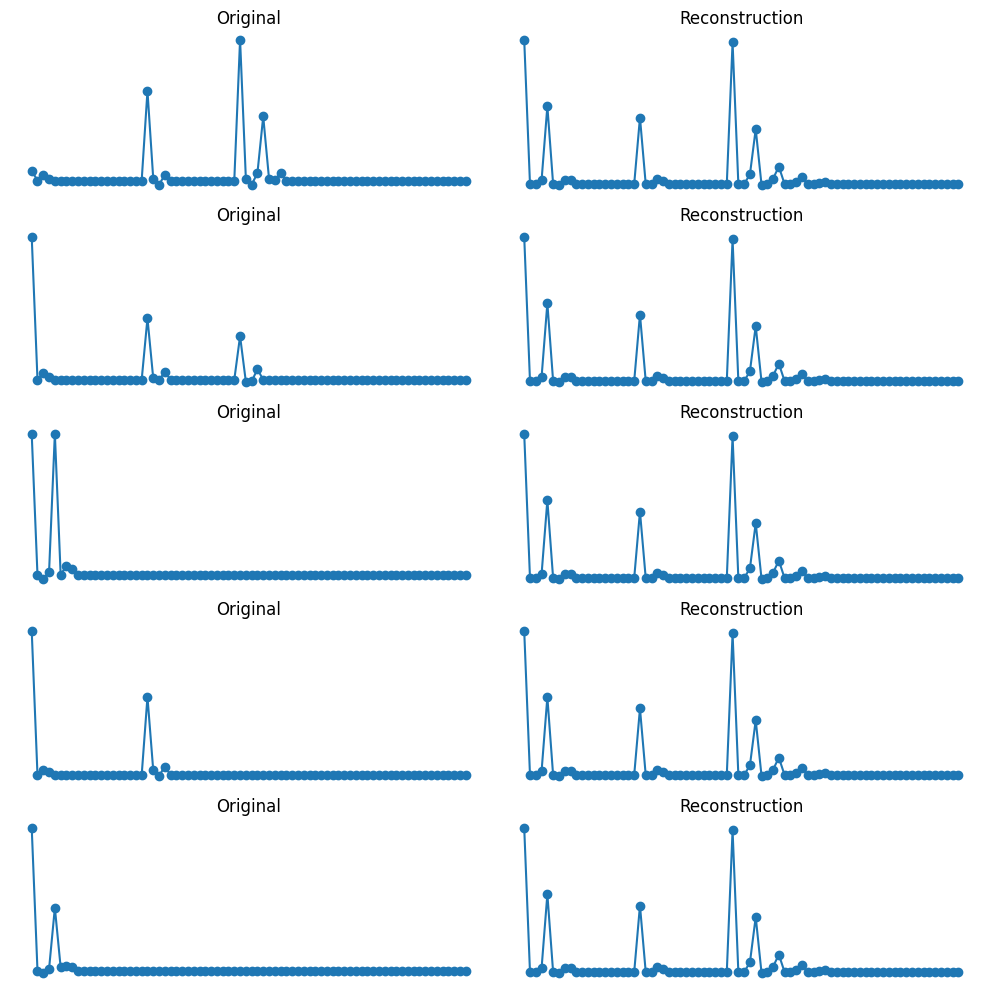

In [9]:

def visualize_reconstructions(vae, data_loader, device, num_samples=5):
    vae.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch[0].to(device)
            batch = batch.view(batch.size(0), -1)  # Flatten if needed
            x_recon, _, _ = vae(batch)
            
            # Select a few samples
            samples = batch[:num_samples]
            reconstructions = x_recon[:num_samples]
            break  # We only need one batch for visualization

    # Convert tensors to numpy arrays
    samples_np = samples.cpu().numpy()
    reconstructions_np = reconstructions.cpu().numpy()

    # Print shapes for debugging
    print(f'Sample shape: {samples_np.shape}')
    print(f'Reconstruction shape: {reconstructions_np.shape}')

    # Plot input vectors and reconstructions
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))
    for i in range(num_samples):
        # Plot original sample
        axes[i, 0].plot(samples_np[i], marker='o')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Plot reconstruction
        axes[i, 1].plot(reconstructions_np[i], marker='o')
        axes[i, 1].set_title('Reconstruction')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_reconstructions(vae, val_loader, device)


In [10]:
# Testing loop
vae.eval()
test_loss = 0
recon_loss_total = 0
kld_loss_total = 0
with torch.no_grad():
    for batch in test_loader:
        batch = batch[0].view(batch[0].size(0), -1).to(device)
        x_recon, mu, logvar = vae(batch)
        total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar)
        test_loss += total_loss.item()
        recon_loss_total += recon_loss.item()
        kld_loss_total += kld_loss.item()
    
    average_test_loss = test_loss / len(test_loader.dataset)
    average_recon_loss = recon_loss_total / len(test_loader.dataset)
    average_kld_loss = kld_loss_total / len(test_loader.dataset)
    print(f' Test Loss: {average_test_loss:.4f}, Recon Loss: {average_recon_loss:.4f}, KLD Loss: {average_kld_loss:.4f}')

 Test Loss: 0.0577, Recon Loss: 0.0577, KLD Loss: -0.0000


In [11]:
# Evaluation on Blackbox data
vae.eval()
blackbox_loss = 0
recon_loss_total = 0
kld_loss_total = 0

with torch.no_grad():
    for batch in blackbox_loader:
        batch = batch[0].view(batch[0].size(0), -1).to(device)
        x_recon, mu, logvar = vae(batch)
        total_loss, recon_loss, kld_loss = loss_function(batch, x_recon, mu, logvar)
        blackbox_loss += total_loss.item()
        recon_loss_total += recon_loss.item()
        kld_loss_total += kld_loss.item()
    
    average_blackbox_loss = blackbox_loss / len(blackbox_loader.dataset)
    average_recon_loss = recon_loss_total / len(blackbox_loader.dataset)
    average_kld_loss = kld_loss_total / len(blackbox_loader.dataset)
    print(f' Blackbox Loss: {average_blackbox_loss:.4f}, Recon Loss: {average_recon_loss:.4f}, KLD Loss: {average_kld_loss:.4f}')

 Blackbox Loss: 0.0066, Recon Loss: 0.0066, KLD Loss: -0.0000


In [24]:


# Define the function to compute the reconstruction error using your existing function
def compute_reconstruction_error(x, x_recon):
    return torch.mean((x - x_recon) ** 2, dim=1)

# Generate latent space representations and calculate reconstruction errors using blackbox_loader
vae.eval()  # Set the VAE to evaluation mode
reconstruction_errors = []
latent_representations = []
originals = []

# Define subsampling parameters
subsample_ratio = 0.5  # Process only 10% of the data
max_batches = 100  # Limit the number of batches processed
processed_batches = 0

In [25]:
# Process batches with subsampling
with torch.no_grad():
    for batch in blackbox_loader:
        # Stop early if max_batches is reached
        if processed_batches >= max_batches:
            break
        
        processed_batches += 1

        # Subsample within the batch
        if isinstance(batch, (tuple, list)):
            batch_data = batch[0]
        else:
            batch_data = batch
        
        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        # Apply subsampling within the batch
        num_samples = int(len(batch_data) * subsample_ratio)
        subsample_indices = np.random.choice(len(batch_data), num_samples, replace=False)
        batch_data = batch_data[subsample_indices]

        # Move data to device
        batch_data = batch_data.to(device)

        # Perform forward pass
        x_recon, mu, logvar = vae(batch_data)

        # Calculate reconstruction error
        error = compute_reconstruction_error(batch_data, x_recon)

        # Store results
        reconstruction_errors.extend(error.cpu().numpy())
        latent_representations.extend(mu.cpu().numpy())
        originals.extend(batch_data.cpu().numpy())


In [26]:
# Convert lists to numpy arrays
reconstruction_errors = np.array(reconstruction_errors)
latent_representations = np.array(latent_representations)
originals = np.array(originals)


In [32]:
print(reconstruction_errors)

[2.4424728e-05 4.0902240e-05 8.6068518e-05 ... 2.0080630e-05 3.4089717e-05
 5.5641794e-05]


In [27]:
# Define a threshold for anomalies (e.g., top 5% of reconstruction errors)
threshold = np.percentile(reconstruction_errors, 95)  # Top 5% as anomalies
anomalies = reconstruction_errors > threshold

In [28]:
# Apply PCA to reduce dimensions before t-SNE (optional but recommended for large datasets)
pca = PCA(n_components=30, random_state=42)
latent_pca = pca.fit_transform(latent_representations)

In [29]:
# Apply t-SNE to the PCA-reduced latent representations
tsne = TSNE(n_components=2, random_state=42, n_iter=500)  # Reduced iterations for speed
latent_tsne = tsne.fit_transform(latent_pca)

/home/hero/miniconda3/envs/pytorch_cuda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hero/miniconda3/envs/pytorch_cuda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


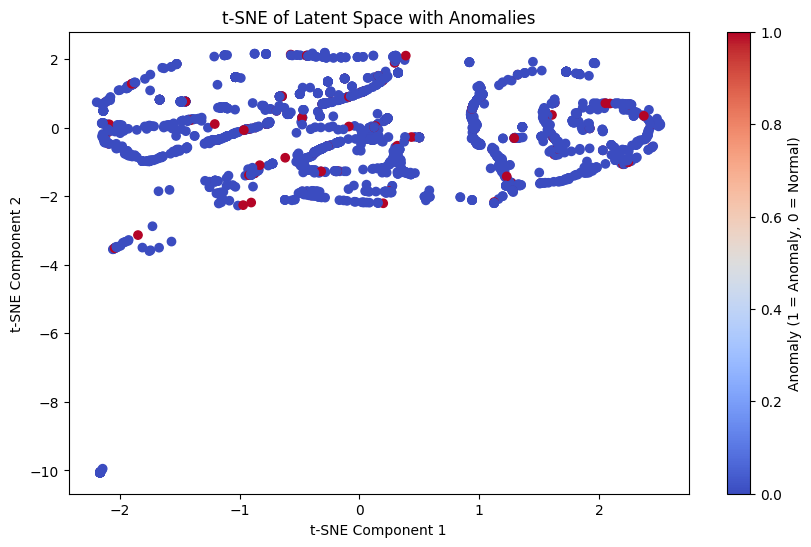

In [30]:
# Plot the t-SNE components, coloring by anomaly status
plt.figure(figsize=(10, 6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=anomalies, cmap='coolwarm', marker='o')
plt.colorbar(label='Anomaly (1 = Anomaly, 0 = Normal)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Latent Space with Anomalies')
plt.show()